In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import h5py 

import jax.numpy as jnp

sys.path.append('../')
from main import * 
from plot_utils import *

5760.0
7200
2.0


In [2]:
dic_attrs = {}
dic_arr = {}
with h5py.File(DATAPATH) as f:
    keys = f.keys()
    print(keys)
    for key in keys:
        arr = jnp.array(f[key][:])

        if 'te' in key:
            arr = jnp.where(arr==0, jnp.nan, arr)
        else:
            arr = arr * 1e-3
        
        arr = arr[:-1, ...]
        dic_arr[key] = arr

    attrs = f.attrs.keys()
    print(attrs)
    for attr in attrs:
        dic_attrs[attr] = f.attrs[attr]

<KeysViewHDF5 ['te_high', 'te_low', 'vz_high', 'vz_low']>
<KeysViewHDF5 ['cellsize', 'metadata', 'simulation', 'units', 'version']>


## 1. Power Spectra

In [3]:
n_k_bins = 300

k_bins, omega, Pk_low = get_k_omega_power(dic_arr['vz_low'], n_k_bins)
k_bins, omega, Pk_high = get_k_omega_power(dic_arr['vz_high'], n_k_bins)

T_low_mean = jnp.nanmean(dic_arr['te_low'])
T_high_mean = jnp.nanmean(dic_arr['te_high'])

cs_low = get_cs(T_low_mean)
cs_high = get_cs(T_high_mean)

In [15]:
2 * jnp.pi / 0.004
1/(3.8*1e-3) / 60
T_low_mean
cs_low
T_high_mean
cs_high

Array(7.1903477, dtype=float32)

In [4]:
vmin, vmax = -8, -2

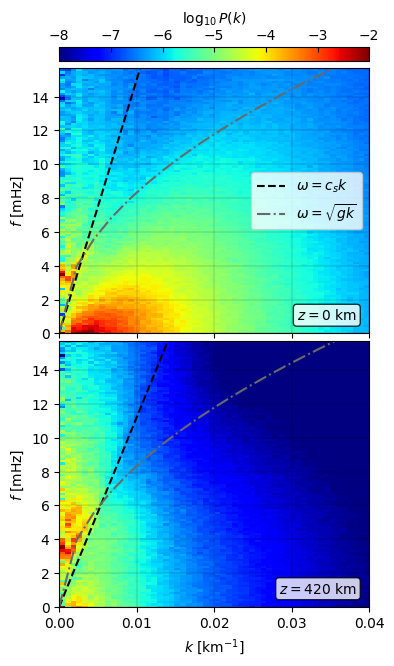

In [13]:
size=4
fig, axs = plt.subplots(2, 1, figsize=(size, size*1.75))
plt.subplots_adjust(wspace=0.0, hspace=0.03)

labels = ['$z=0$ km', '$z=420$ km']
alpha = 0.8
cmap = 'jet'

f = omega / (2*jnp.pi) * 1e3
K, OMEGA = jnp.meshgrid(k_bins, f)
ks = jnp.linspace(0, k_bins.max(), 100)

im0 = axs[0].pcolormesh(K, OMEGA, jnp.log10(Pk_low), cmap=cmap, vmin=vmin, vmax=vmax)
axs[0].plot(ks, cs_low*ks* 1e3 / (2*jnp.pi), c='k', ls='--', label=r'$\omega = c_s k$')


cmap = plt.get_cmap(cmap)
vlim = np.linspace(vmin, vmax, 10)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(vlim)
pos = axs[0].get_position()
cbar_ax = fig.add_axes([pos.x0, pos.y1+0.01, pos.width, 0.02])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
cbar_ax.tick_params(
    bottom=False, top=True, labelbottom=False, labeltop=True, direction="in"
)
cbar_ax.xaxis.set_label_position("top")
cbar_ax.set_xlabel(r"$\log_{10} P(k)$")
axs[0].text(
    0.96,
    0.04,
    labels[0],
    ha="right",
    va="bottom",
    transform=axs[0].transAxes,
    fontsize=10,
    c="k",
    bbox=dict(
        facecolor="white", edgecolor="black", boxstyle="round,pad=0.25", alpha=alpha
    ),
)


im1 = axs[1].pcolormesh(K, OMEGA, jnp.log10(Pk_high), cmap=cmap, vmin=vmin, vmax=vmax)
axs[1].plot(ks, cs_high*ks* 1e3 / (2*jnp.pi), c='k', ls='--')
axs[1].text(
    0.96,
    0.04,
    labels[1],
    ha="right",
    va="bottom",
    transform=axs[1].transAxes,
    fontsize=10,
    c="k",
    bbox=dict(
        facecolor="white", edgecolor="black", boxstyle="round,pad=0.25", alpha=alpha
    ),
)


omega_prime = jnp.sqrt(ks*G_SURF) * 1e3 / (2*jnp.pi)

axs[0].tick_params(labelbottom=False)

axs[1].set_xlabel('$k$ [km$^{-1}$]')

axs[0].plot(ks, omega_prime, ls='-.', c='dimgrey', label=r'$\omega = \sqrt{g k}$')
axs[1].plot(ks, omega_prime, ls='-.', c='dimgrey')

axs[0].legend(loc='center right')

for ax in axs:
    ax.set_xlim(0, 0.04)
    ax.set_ylim(0, 15.7)
    
    ax.set_ylabel(r'$f$ [mHz]')

    ax.grid(
        which="major",
        linewidth=0.25,
        color="k",
        alpha=0.5,
    )

savepath = '../figures/plot_2.png'
fig.savefig(savepath, dpi=300, bbox_inches='tight')

## 2. Histograms

In [14]:
n_bins = 75

v_low_lim = max(jnp.abs(jnp.min(dic_arr['vz_low'])), jnp.max(dic_arr['vz_low'])) 
v_low_bins = jnp.linspace(-v_low_lim, v_low_lim, n_bins)
v_hist_low, v_edges_low = jnp.histogram(dic_arr['vz_low'], bins=v_low_bins)
v_low_width = jnp.diff(v_edges_low)

v_high_lim = max(jnp.abs(jnp.min(dic_arr['vz_high'])), jnp.max(dic_arr['vz_high'])) * 0.5
v_high_bins = jnp.linspace(-v_high_lim, v_high_lim, n_bins)
v_hist_high, v_edges_high = jnp.histogram(dic_arr['vz_high'], bins=v_high_bins)
v_high_width = jnp.diff(v_edges_high)

t_low_min = jnp.nanmin(dic_arr['te_low'])
t_low_max = jnp.nanmax(dic_arr['te_low']) 
t_low_bins = jnp.linspace(t_low_min, t_low_max, n_bins)
t_hist_low, t_edges_low = jnp.histogram(dic_arr['te_low'], bins=t_low_bins)
t_low_width = jnp.diff(t_edges_low)


t_high_min = jnp.nanmin(dic_arr['te_high'])
t_high_max = jnp.nanmax(dic_arr['te_high']) 
t_high_bins = jnp.linspace(t_high_min, t_high_max, n_bins)
t_hist_high, t_edges_high = jnp.histogram(dic_arr['te_high'], bins=t_high_bins)
t_high_width = jnp.diff(t_edges_high)

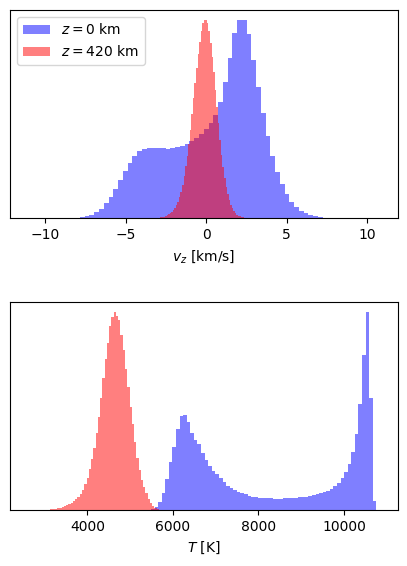

In [28]:
size=5
fig, axs = plt.subplots(2, 1, figsize=(size, size*1.3))
plt.subplots_adjust(wspace=0.01, hspace=0.4)

axs[0].bar(v_edges_low[:-1], v_hist_low/v_hist_low.max(), width=v_low_width, alpha=0.5, color='b', label=labels[0])
axs[0].bar(v_edges_high[:-1], v_hist_high/v_hist_high.max(), width=v_high_width, alpha=0.5, color='r', label=labels[1])
axs[0].set_xlabel('$v_z$ [km/s]')
axs[0].legend(loc='upper left')


axs[1].bar(t_edges_low[:-1], t_hist_low/t_hist_low.max(), width=t_low_width, alpha=0.5, color='b', label=labels[0])
axs[1].bar(t_edges_high[:-1], t_hist_high/t_hist_high.max(), width=t_high_width, alpha=0.5, color='r', label=labels[1])
axs[1].set_xlabel('$T$ [K]')
# axs[1].legend(loc='upper left')


for ax in axs:
    ax.tick_params(left=False, labelleft=False)

savepath = '../figures/plot_3.png'
fig.savefig(savepath, dpi=300, bbox_inches='tight')

## 3. Correlations

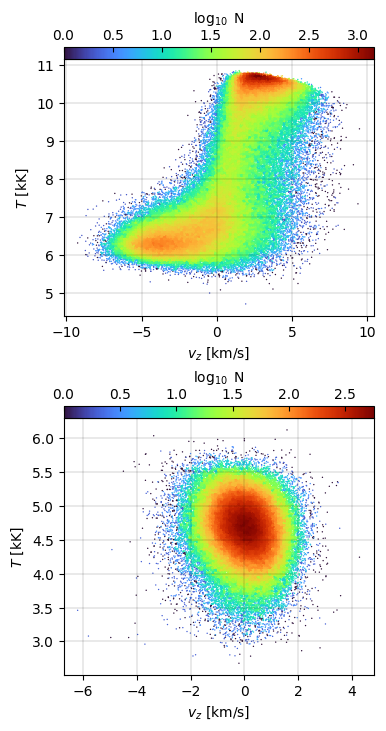

In [41]:
size = 4
fig, axs = plt.subplots(2, 1, figsize=(size, size*2))
plt.subplots_adjust(wspace=0.01, hspace=0.4)

step = 100
s = 1
scatter_density(fig, axs[0], dic_arr["vz_low"], dic_arr["te_low"]/1e3, step=step, s=s)
axs[0].set_xlabel('$v_z$ [km/s]')
axs[0].set_ylabel('$T$ [kK]')

scatter_density(fig, axs[1], dic_arr["vz_high"], dic_arr["te_high"]/1e3, step=step, s=s)

for ax in axs:
    ax.grid(
        which="major",
        linewidth=0.25,
        color="k",
        alpha=0.5,
    )
axs[1].set_xlabel('$v_z$ [km/s]')
axs[1].set_ylabel('$T$ [kK]')

#axs[1].tick_params(right=True, labelright=True, left=False, labelleft=False)

savepath = '../figures/plot_4.png'
fig.savefig(savepath, dpi=300, bbox_inches='tight')